### Question 4
Are discontinued items have a difference discount rate compared to the rest of the items?

### Importing Python Module 

In [1]:
from importlib import reload

import numpy as np
import pandas as pd

import sqlite3

# Removing red warnings
import warnings
warnings.filterwarnings('ignore')

# Power Analysis
from statsmodels.stats.power import tt_ind_solve_power,ttest_power

#For tukey test
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

#
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
figsize = (13,8)

import function as func

import scipy.stats as scs


ip


In [2]:
conn = func.MyConn(filename= 'Northwind_small.sqlite')

In [3]:
query =  """
            SELECT o.OrderDate, od.UnitPrice, od.Quantity, p.Discontinued, od.Discount
            from OrderDetail as od
            join 'Order' as o
            on o.Id = od.OrderId
            join Product as p
            on p.Id = od.ProductId
        """


In [4]:
conn.get_table_description(table_name='OrderDetail')

['Id', 'OrderId', 'ProductId', 'UnitPrice', 'Quantity', 'Discount']

In [5]:
df = conn.load_query_as_df(query)
df['Total'] = df.Quantity* df.UnitPrice
df['DateTimeOrder'] = pd.to_datetime(df.OrderDate)
df['YrMonth'] = df.OrderDate.apply(lambda x: x[:7])
df['Count'] = df.OrderDate.apply(lambda x:1)
df.head()

,OrderDate,UnitPrice,Quantity,Discontinued,Discount,Total,DateTimeOrder,YrMonth,Count
0,2012-07-04,14.0,12,0,0.0,168.0,2012-07-04,2012-07,1
1,2012-07-04,9.8,10,1,0.0,98.0,2012-07-04,2012-07,1
2,2012-07-04,34.8,5,0,0.0,174.0,2012-07-04,2012-07,1
3,2012-07-05,18.6,9,0,0.0,167.4,2012-07-05,2012-07,1
4,2012-07-05,42.4,40,0,0.0,1696.0,2012-07-05,2012-07,1


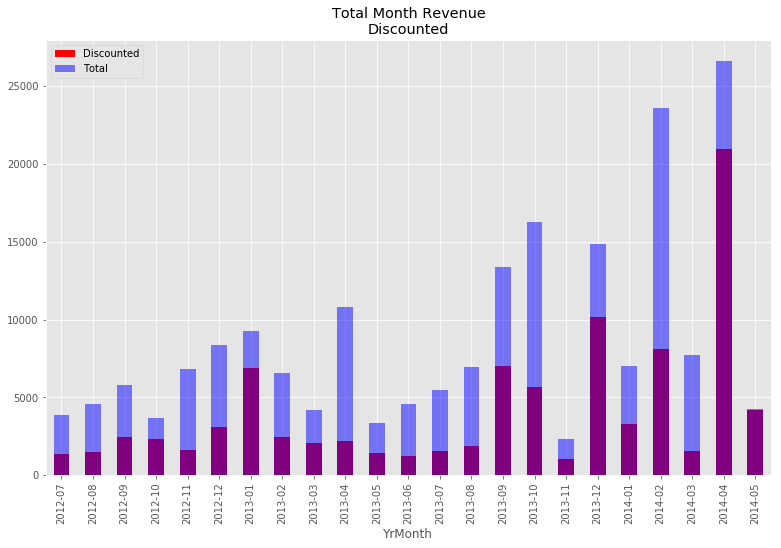

In [6]:
func.plotset(title= 'Total Month Revenue\nDiscounted')

df.loc[df.Discontinued == 1].loc[df.Discount > 0].groupby('YrMonth').sum().Total.plot(kind='bar', color='red', 
                                                                                      alpha =1, label='Discounted');
df.loc[df.Discontinued == 1].loc[df.Discount >= 0
                                ].groupby('YrMonth').sum().Total.plot(kind='bar', color='blue', 
                                                                      alpha =0.5, label= 'Total');
plt.legend();


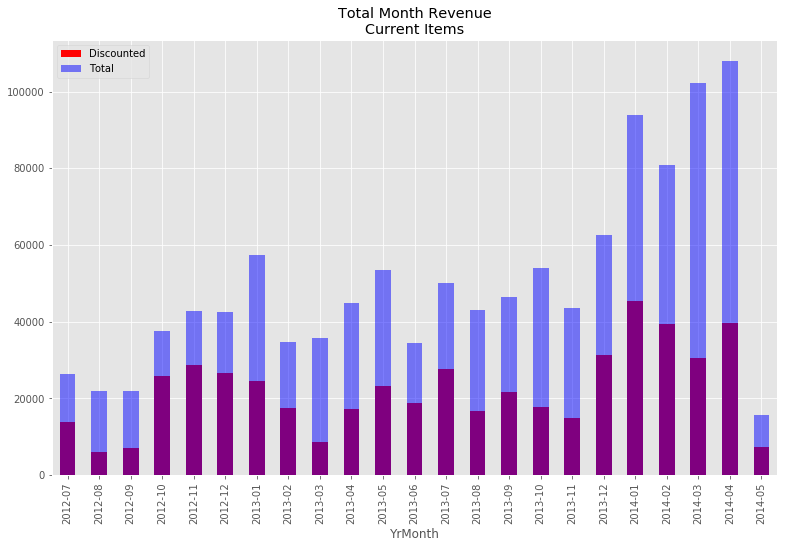

In [7]:
func.plotset(title= 'Total Month Revenue\nCurrent Items')
df.loc[df.Discontinued == 0].loc[df.Discount > 0].groupby('YrMonth').sum().Total.plot(kind='bar', color='red', 
                                                                                      alpha =1, label='Discounted');
df.loc[df.Discontinued == 0].loc[df.Discount >= 0].groupby('YrMonth').sum().Total.plot(kind='bar', color='blue', 
                                                                                       alpha =0.5, label='Total');
plt.legend();

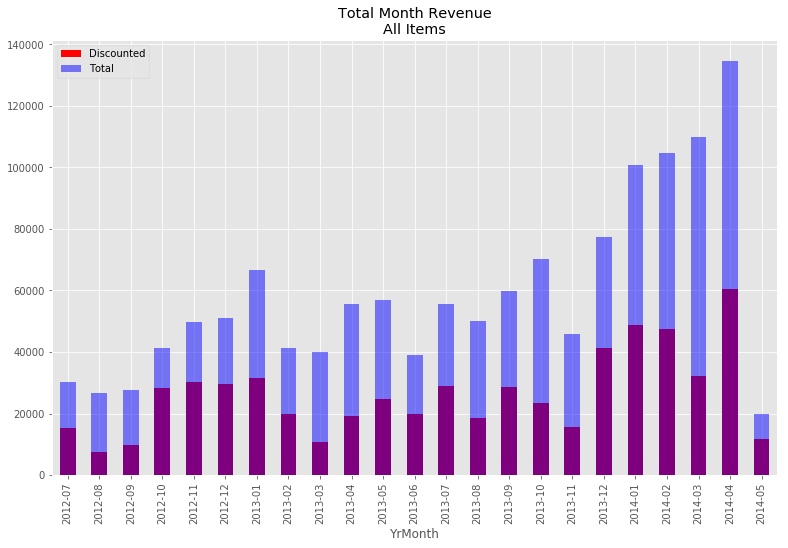

In [8]:
func.plotset(title= 'Total Month Revenue\nAll Items')
df.loc[df.Discount > 0].groupby('YrMonth').sum().Total.plot(kind='bar', color='red', alpha =1, label='Discounted');
df.loc[df.Discount >= 0].groupby('YrMonth').sum().Total.plot(kind='bar', color='blue', alpha =0.5, label='Total');
plt.legend();

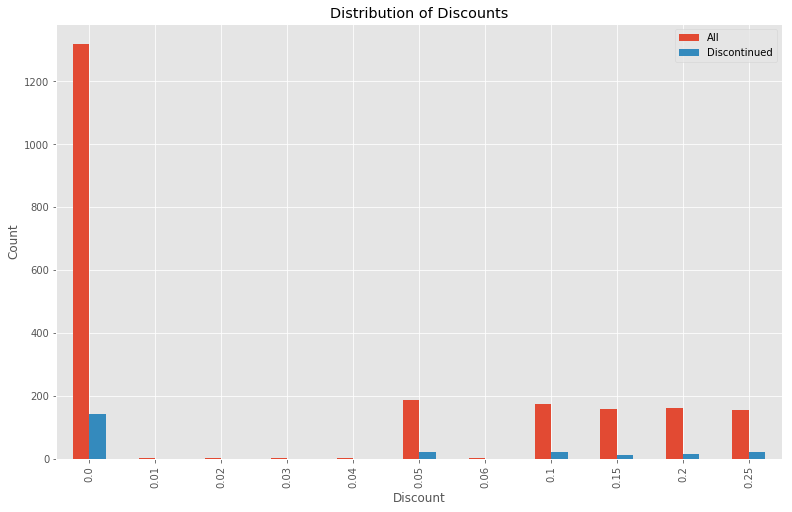

In [9]:
a = df.groupby(['Discount'])['Count', 'Discontinued'].sum()
a = a.rename(columns={'Count':'All'})
ax = a.plot.bar(figsize=(13,8));
plt.title('Distribution of Discounts');
plt.ylabel('Count');


#### Check for normality- Sharpio-Welk test



In [10]:
print('All')
print(func.shapiro_normal(df.Discount))
print('Discontinued')
print(func.shapiro_normal(df.loc[df.Discontinued == 1].Discount))
print('Normal')
print(func.shapiro_normal(df.loc[df.Discontinued == 0].Discount))

All
non normal
t 0.6950738430023193, p 0.0
Discontinued
non normal
t 0.6778910160064697, p 1.3102864828060304e-20
Normal
non normal
t 0.6968779563903809, p 0.0


#### Test analysis
The null hypothesis is that the tested distribution is normally distributed, and the alternative hypothesis is that the distribution is non-normal. A p values threshold is 0.05.

Reject the null hypothesis. All 3 distrbutions are non normal. Will use bootstrapping and will examine sample means.

In [11]:
all_sample_mean = func.bootstrapping(df.Discount, num_of_samples=1000)

In [12]:
discontinued_sample_mean = func.bootstrapping(df.loc[df.Discontinued == 1].Discount, 
                                          num_of_samples=1000)

In [13]:
normal_sample_mean = func.bootstrapping(df.loc[df.Discontinued == 0].Discount,
                                        num_of_samples=1000)

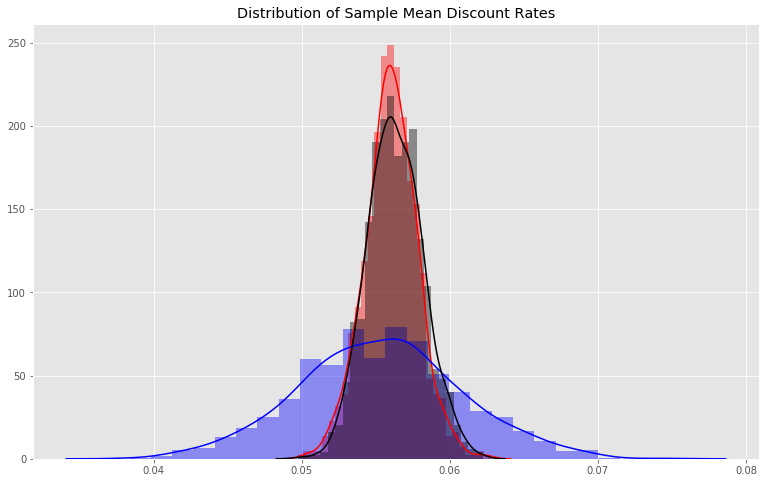

In [29]:
func.plotset(title='Distribution of Sample Mean Discount Rates');
sns.distplot(all_sample_mean, label='Total', color='red');
sns.distplot(discontinued_sample_mean, label='Discontinued', color='blue');
sns.distplot(normal_sample_mean, label='Normal',color='black');

#### Check for normality- Sharpio-Welk test



In [15]:
print('All')
print(func.shapiro_normal(all_sample_mean))
print('Discontinued')
print(func.shapiro_normal(discontinued_sample_mean))
print('Normal')
print(func.shapiro_normal(normal_sample_mean))

All
non normal
t 0.9964560270309448, p 0.023196538910269737
Discontinued
normal
t 0.9987639784812927, p 0.7313024997711182
Normal
normal
t 0.998462438583374, p 0.5303573608398438


#### Test analysis
The null hypothesis is that the tested distribution is normally distributed, and the alternative hypothesis is that the distribution is non-normal. A p values threshold is 0.05.

The null failed to be rejected. The distrubtion can be considered normal.

#### Variance Test

In [16]:
# Total distribution Versus the non discontinued sample.
func.levene_variances(all_sample_mean, normal_sample_mean)

p = 0.04816569617190274
Therefore the data do not have equal variances


False

In [17]:
# Total distribtuion versus the discontinued samples.
func.levene_variances(all_sample_mean, discontinued_sample_mean)

p = 1.2284988167112896e-134
Therefore the data do not have equal variances


False

In [18]:
#Non discontinued samples versus the discontinued samples
func.levene_variances(discontinued_sample_mean, normal_sample_mean)

p = 3.854038813759604e-127
Therefore the data do not have equal variances


False

The discontinued samples had difference variance compared to the other distributions.

#### Effect Size

In [19]:
# Total distribution Versus the non discontinued sample.
func.cohen_d(all_sample_mean, normal_sample_mean)

-0.1523233592759832

In [20]:
# Total distribtuion versus the discontinued samples.
func.cohen_d(all_sample_mean, discontinued_sample_mean)

0.1826323674984884

In [21]:
#Non discontinued samples versus the discontinued samples
func.cohen_d(discontinued_sample_mean, normal_sample_mean)

-0.2499484603113419

The effect size are not very big, and would cause question a reject of the null hypothesis in a Welch's T test

#### Welch T Test

In [22]:
scs.ttest_ind(discontinued_sample_mean, normal_sample_mean, equal_var=False)

Ttest_indResult(statistic=-5.589017481275687, pvalue=2.8111357710968543e-08)

In [23]:
scs.ttest_ind(all_sample_mean, discontinued_sample_mean, equal_var=False)

Ttest_indResult(statistic=4.083783886183433, pvalue=4.7219796460801225e-05)

#### Test analysis
Failed to reject the null hypothesis(the sample means are identical)


### Conclusion 
There is not statistical signficant difference in between discount rate of the discontinued items versus either 

In [28]:
!jupyter nbconvert --to markdown question4

[NbConvertApp] Converting notebook question4.ipynb to markdown
[NbConvertApp] Support files will be in question4_files\
[NbConvertApp] Making directory question4_files
[NbConvertApp] Making directory question4_files
[NbConvertApp] Making directory question4_files
[NbConvertApp] Making directory question4_files
[NbConvertApp] Making directory question4_files
[NbConvertApp] Writing 9589 bytes to question4.md
